# Overvew
- nb010のresnet18をresnet34に変更 

# CONST

In [1]:
NB = '014'
DEBUG = False
PERIOD = 5
DATASET = '32khz'
DIR_MODEL = './../data_ignore/model'

In [2]:
settings_str = """
globals:
  seed: 1213
  device: cuda
  num_epochs: 50
  output_dir: /kaggle/training_output/
  use_fold: 0
  target_sr: 32000

dataset:
  name: SpectrogramDataset
  params:
    img_size: 224
    melspectrogram_parameters:
      n_mels: 128
      fmin: 20
      fmax: 16000
    
split:
  name: StratifiedKFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 40
    shuffle: True
    num_workers: 5
    pin_memory: True
    drop_last: True
  val:
    batch_size: 40
    shuffle: False
    num_workers: 5
    pin_memory: True
    drop_last: False

model:
  name: resnest50_fast_1s1x64d
  params:
    pretrained: True
    n_classes: 264

loss:
  name: BCEWithLogitsLoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.001

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [3]:
import os
import gc
import cv2 
import time
import yaml
import random
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from fastprogress import progress_bar
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torchvision import models
import torch.utils.data as data

import sys
sys.path.insert(0, './../src/util/')
from const import BIRD_CODE, INV_BIRD_CODE

/usr/local/lib/python3.6/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


# My function

In [4]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore

In [5]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

In [6]:
class SpectrogramDataset(data.Dataset):
    def __init__(self, file_list, img_size=224, 
                 waveform_transforms=None, spectrogram_transforms=None, melspectrogram_parameters={}):
        
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.img_size = img_size
        self.waveform_transforms = waveform_transforms
        self.spectrogram_transforms = spectrogram_transforms
        self.melspectrogram_parameters = melspectrogram_parameters

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)
#         sr, y = wavfile.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        melspec = librosa.feature.melspectrogram(y, sr=sr, **self.melspectrogram_parameters)
        melspec = librosa.power_to_db(melspec).astype(np.float32)

        if self.spectrogram_transforms:
            melspec = self.spectrogram_transforms(melspec)
        else:
            pass

        image = mono_to_color(melspec)
        height, width, _ = image.shape
        image = cv2.resize(image, (int(width * self.img_size / height), self.img_size))
        image = np.moveaxis(image, 2, 0)
        image = (image / 255.0).astype(np.float32)

#         labels = np.zeros(len(BIRD_CODE), dtype="i")
        labels = np.zeros(len(BIRD_CODE), dtype="f")
        labels[BIRD_CODE[ebird_code]] = 1

        return image, labels

In [7]:
def get_loaders_for_training(args_dataset, args_loader, train_file_list, val_file_list):
    # # make dataset
    train_dataset = SpectrogramDataset(train_file_list, **args_dataset)
    val_dataset = SpectrogramDataset(val_file_list, **args_dataset)
    # # make dataloader
    train_loader = data.DataLoader(train_dataset, **args_loader["train"])
    val_loader = data.DataLoader(val_dataset, **args_loader["val"])
    
    return train_loader, val_loader

# Preparation

settings

In [8]:
pd.set_option('display.max_columns', 100)

In [9]:
settings = yaml.safe_load(settings_str)
for k, v in settings.items():
    print("[{}]".format(k))
    print(v)

[globals]
{'seed': 1213, 'device': 'cuda', 'num_epochs': 50, 'output_dir': '/kaggle/training_output/', 'use_fold': 0, 'target_sr': 32000}
[dataset]
{'name': 'SpectrogramDataset', 'params': {'img_size': 224, 'melspectrogram_parameters': {'n_mels': 128, 'fmin': 20, 'fmax': 16000}}}
[split]
{'name': 'StratifiedKFold', 'params': {'n_splits': 5, 'random_state': 42, 'shuffle': True}}
[loader]
{'train': {'batch_size': 40, 'shuffle': True, 'num_workers': 5, 'pin_memory': True, 'drop_last': True}, 'val': {'batch_size': 40, 'shuffle': False, 'num_workers': 5, 'pin_memory': True, 'drop_last': False}}
[model]
{'name': 'resnest50_fast_1s1x64d', 'params': {'pretrained': True, 'n_classes': 264}}
[loss]
{'name': 'BCEWithLogitsLoss', 'params': {}}
[optimizer]
{'name': 'Adam', 'params': {'lr': 0.001}}
[scheduler]
{'name': 'CosineAnnealingLR', 'params': {'T_max': 10}}


<br>

data path

In [10]:
root = Path.cwd().parent
input_ex_root = root / 'data_ignore/external_dataset' / DATASET
train_resampled_audio_dirs = [input_ex_root / "birdsong-resampled-train-audio-{:0>2}"
                              .format(i)  for i in range(5)]

In [11]:
train_resampled_audio_dirs

[PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-00'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-01'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-02'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-03'),
 PosixPath('/home/user/Git/kaggle-Cornell-Birdcall-Identification/data_ignore/external_dataset/32khz/birdsong-resampled-train-audio-04')]

<br>

load data

In [12]:
train = pd.read_csv(train_resampled_audio_dirs[0] / "train_mod.csv")
train.head(2).T

,0,1
rating,3.5,4
playback_used,no,no
ebird_code,aldfly,aldfly
channels,1 (mono),2 (stereo)
date,2013-05-25,2013-05-27
pitch,Not specified,both
duration,25,36
filename,XC134874.mp3,XC135454.mp3
speed,Not specified,both
species,Alder Flycatcher,Alder Flycatcher


# Execution

<br>

train_all を作成  
train_all: リサンプル後のファイルパスなどを追加

In [13]:
tmp_list = []
for audio_d in train_resampled_audio_dirs:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

(21375, 38)
(21375, 3)
(21375, 39)


<br>

fold

In [14]:
skf = StratifiedKFold(**settings["split"]["params"])

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id

In [15]:
use_fold = settings["globals"]["use_fold"]
idx_train = train_all['fold']!=use_fold
idx_valid = train_all['fold']==use_fold
train_file_list = train_all[idx_train][['file_path', 'ebird_code']].values.tolist()
valid_file_list = train_all[idx_valid][['file_path', 'ebird_code']].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(valid_file_list)))

[fold 0] train: 17057, val: 4318


In [16]:
len(train_file_list)+len(valid_file_list)

21375

<br>

train

In [17]:
device = torch.device(settings['globals']['device'])

In [18]:
set_seed(settings['globals']['seed'])

In [19]:
# # # get loader
train_loader, valid_loader = get_loaders_for_training(
    settings["dataset"]["params"], settings["loader"], train_file_list, valid_file_list)

In [20]:
# resnet50 のファインチューニング
# model = models.resnet18(pretrained=True)
model = models.resnet34(pretrained=True)
# model = models.resnet50(pretrained=True)
# model.fc = nn.Linear(in_features=2048, out_features=len(BIRD_CODE))
model.fc = nn.Linear(in_features=512, out_features=len(BIRD_CODE))
model = model.to(device)

In [21]:
# # # get optimizer
optimizer = getattr(
        torch.optim, settings["optimizer"]["name"]
        )(model.parameters(), **settings["optimizer"]["params"])

# # # get scheduler
scheduler = getattr(
    torch.optim.lr_scheduler, settings["scheduler"]["name"]
    )(optimizer, **settings["scheduler"]["params"])

# # # get loss
loss_func = getattr(nn, settings["loss"]["name"])(**settings["loss"]["params"])

In [22]:
def train(model, device, train_loader, optimizer, scheduler, loss_func):
    model.train()
    epoch_train_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_train_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_train_loss / len(train_loader.dataset)
                return loss
    loss = epoch_train_loss / len(train_loader.dataset)
    del data
    return loss
        
def get_epoch_loss(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_valid_loss / len(valid_loader.dataset)
                return loss
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

def evaluate(model, device, valid_loder, loss_func):
    model.eval()
    epoch_valid_loss = 0
    for batch_idx, (data, target) in enumerate(progress_bar(valid_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, preds = torch.max(outputs, 1)
        loss = loss_func(output, target)
        epoch_valid_loss += loss.item()*data.size(0)
        if DEBUG == True:
            if batch_idx > 0:
                loss = epoch_valid_loss / len(valid_loader.dataset)
                return loss
    
    loss = epoch_valid_loss / len(valid_loader.dataset)
    del data
    return loss

In [23]:
losses_train = []
losses_valid = []

n_epoch = 3 if DEBUG==True else settings['globals']['num_epochs']
for epoch in progress_bar(range(n_epoch)):
    print(f'\n epoch: {epoch+1} {time.ctime()}')
    loss_train = train(model, device, train_loader, optimizer, scheduler, loss_func)
    loss_valid = get_epoch_loss(model, device, valid_loader, loss_func)
    print(f'loss_train: {loss_train}, loss_valid: {loss_valid}\n')
    
    losses_train.append(loss_train)
    losses_valid.append(loss_valid)


 epoch: 1 Fri Aug 14 21:47:29 2020


loss_train: 0.0299659749430649, loss_valid: 0.023323925741745015


 epoch: 2 Fri Aug 14 22:00:10 2020


loss_train: 0.02097711712253005, loss_valid: 0.020098634522309894


 epoch: 3 Fri Aug 14 22:12:50 2020


loss_train: 0.018724020197703632, loss_valid: 0.01744166607465966


 epoch: 4 Fri Aug 14 22:25:29 2020


loss_train: 0.01704753595764964, loss_valid: 0.018227717624791744


 epoch: 5 Fri Aug 14 22:38:08 2020


loss_train: 0.015618912644145734, loss_valid: 0.017570036641594268


 epoch: 6 Fri Aug 14 22:50:48 2020


loss_train: 0.014411398044901408, loss_valid: 0.014351056381411273


 epoch: 7 Fri Aug 14 23:03:28 2020


loss_train: 0.013289997972119503, loss_valid: 0.016664442276705493


 epoch: 8 Fri Aug 14 23:16:06 2020


loss_train: 0.012489465471692792, loss_valid: 0.014634257814432389


 epoch: 9 Fri Aug 14 23:28:49 2020


loss_train: 0.011694779945103373, loss_valid: 0.013959702028409371


 epoch: 10 Fri Aug 14 23:41:35 2020


loss_train: 0.010892728964633313, loss_valid: 0.01934894605359859


 epoch: 11 Fri Aug 14 23:54:25 2020


loss_train: 0.010229544349907152, loss_valid: 0.014634117186449093


 epoch: 12 Sat Aug 15 00:07:09 2020


loss_train: 0.009685377152734383, loss_valid: 0.012629634286171311


 epoch: 13 Sat Aug 15 00:19:52 2020


loss_train: 0.009134516905987326, loss_valid: 0.011056038531621003


 epoch: 14 Sat Aug 15 00:32:32 2020


loss_train: 0.008533659470876663, loss_valid: 0.011987678095829492


 epoch: 15 Sat Aug 15 00:45:15 2020


loss_train: 0.008181282426964715, loss_valid: 0.014086905365612232


 epoch: 16 Sat Aug 15 00:57:54 2020


loss_train: 0.007809412188401233, loss_valid: 0.010655357023582878


 epoch: 17 Sat Aug 15 01:10:35 2020


loss_train: 0.007229625636885019, loss_valid: 0.012164231019216232


 epoch: 18 Sat Aug 15 01:23:16 2020


loss_train: 0.006906538308470499, loss_valid: 0.011582544042404021


 epoch: 19 Sat Aug 15 01:36:04 2020


loss_train: 0.006705693331210032, loss_valid: 0.011382901096382644


 epoch: 20 Sat Aug 15 01:48:46 2020


loss_train: 0.006261282960990253, loss_valid: 0.011323888355632273


 epoch: 21 Sat Aug 15 02:01:29 2020


loss_train: 0.005961679727644534, loss_valid: 0.011637064629165786


 epoch: 22 Sat Aug 15 02:14:13 2020


loss_train: 0.005775536388397294, loss_valid: 0.011589851587986632


 epoch: 23 Sat Aug 15 02:26:59 2020


loss_train: 0.005443962828153049, loss_valid: 0.010754293860499232


 epoch: 24 Sat Aug 15 02:39:42 2020


loss_train: 0.00522600858213317, loss_valid: 0.014486784111551385


 epoch: 25 Sat Aug 15 02:52:26 2020


loss_train: 0.005035909681620328, loss_valid: 0.012616818670257615


 epoch: 26 Sat Aug 15 03:05:10 2020


loss_train: 0.0048071582791648125, loss_valid: 0.011387636066311319


 epoch: 27 Sat Aug 15 03:17:57 2020


loss_train: 0.004689285920177981, loss_valid: 0.01154296966153143


 epoch: 28 Sat Aug 15 03:30:37 2020


loss_train: 0.00444515526759687, loss_valid: 0.011855837684978816


 epoch: 29 Sat Aug 15 03:43:21 2020


loss_train: 0.00424050493916609, loss_valid: 0.011193144274940227


 epoch: 30 Sat Aug 15 03:56:01 2020


loss_train: 0.004136426915244441, loss_valid: 0.012808071016305959


 epoch: 31 Sat Aug 15 04:08:43 2020


loss_train: 0.003967903851030049, loss_valid: 0.01662414677910448


 epoch: 32 Sat Aug 15 04:21:27 2020


loss_train: 0.003895881490389543, loss_valid: 0.011777958893935373


 epoch: 33 Sat Aug 15 04:34:13 2020


loss_train: 0.0037097681631856273, loss_valid: 0.013118427152770876


 epoch: 34 Sat Aug 15 04:46:54 2020


loss_train: 0.0036842874762094747, loss_valid: 0.012518685529351014


 epoch: 35 Sat Aug 15 04:59:39 2020


loss_train: 0.0034413308753908998, loss_valid: 0.01301983731353225


 epoch: 36 Sat Aug 15 05:12:20 2020


loss_train: 0.003514087313089773, loss_valid: 0.01198523306693742


 epoch: 37 Sat Aug 15 05:25:00 2020


loss_train: 0.0032567697185801317, loss_valid: 0.011851438369486359


 epoch: 38 Sat Aug 15 05:37:46 2020


loss_train: 0.0032421096855478697, loss_valid: 0.012901201710922815


 epoch: 39 Sat Aug 15 05:50:32 2020


loss_train: 0.0031087187754051775, loss_valid: 0.012099161927017585


 epoch: 40 Sat Aug 15 06:03:21 2020


loss_train: 0.00290853623497353, loss_valid: 0.012769107780608661


 epoch: 41 Sat Aug 15 06:16:02 2020


loss_train: 0.003014756604669179, loss_valid: 0.013042439534939262


 epoch: 42 Sat Aug 15 06:28:53 2020


loss_train: 0.0028965649852788957, loss_valid: 0.01253481616791046


 epoch: 43 Sat Aug 15 06:41:38 2020


loss_train: 0.0028282215840002415, loss_valid: 0.012221978859127866


 epoch: 44 Sat Aug 15 06:54:23 2020


loss_train: 0.0026077669754721775, loss_valid: 0.0136381299457081


 epoch: 45 Sat Aug 15 07:07:05 2020


loss_train: 0.0026496538739834243, loss_valid: 0.01246796348945321


 epoch: 46 Sat Aug 15 07:19:49 2020


loss_train: 0.0025765497307387304, loss_valid: 0.012618023689944968


 epoch: 47 Sat Aug 15 07:32:30 2020


loss_train: 0.002556430296526853, loss_valid: 0.013126792732993725


 epoch: 48 Sat Aug 15 07:45:13 2020


loss_train: 0.002437901170506611, loss_valid: 0.0154235223821533


 epoch: 49 Sat Aug 15 07:57:55 2020


loss_train: 0.0022800751915520957, loss_valid: 0.01273673891826201


 epoch: 50 Sat Aug 15 08:10:36 2020


loss_train: 0.002373373830717079, loss_valid: 0.013107452421669554



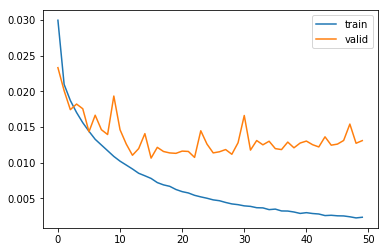

In [24]:
plt.plot(losses_train, label='train')
plt.plot(losses_valid, label='valid')
plt.legend()

In [25]:
del train_loader
# del valid_loader
# del model
del optimizer
del scheduler
del loss_func

gc.collect()

0

# save model

In [26]:
save_dir = f'{DIR_MODEL}/nb{NB}_{model.__class__.__name__}/'
file_dir = os.path.dirname(save_dir)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

In [27]:
save_path = f'{save_dir}model_{model.__class__.__name__}.pth'
save_path

'./../data_ignore/model/nb014_ResNet/model_ResNet.pth'

In [28]:
if DEBUG == True:
    pass
else:
    torch.save(model.state_dict(), save_path)

# check model

In [29]:
if DEBUG == True:
    pass
else:
    load_weights = torch.load(save_path)
    model.load_state_dict(load_weights)